Shyju Kozhisseri<br/>ID: 309572<br/>Group: J41323c

## Import Data

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)

In [23]:
input = pd.read_csv('garments_worker_productivity.csv')

In [24]:
input.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [25]:
input.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [26]:
input.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [27]:
sub_sample = input[['team','smv', 'no_of_workers', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'targeted_productivity', 'actual_productivity']]
sub_sample

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
0,8,26.16,59.0,1108.0,7080,98,0.0,0,0,0.80,0.940725
1,1,3.94,8.0,NaN,960,0,0.0,0,0,0.75,0.886500
2,11,11.41,30.5,968.0,3660,50,0.0,0,0,0.80,0.800570
3,12,11.41,30.5,968.0,3660,50,0.0,0,0,0.80,0.800570
4,6,25.90,56.0,1170.0,1920,50,0.0,0,0,0.80,0.800382
...,...,...,...,...,...,...,...,...,...,...,...
1192,10,2.90,8.0,NaN,960,0,0.0,0,0,0.75,0.628333
1193,8,3.90,8.0,NaN,960,0,0.0,0,0,0.70,0.625625
1194,7,3.90,8.0,NaN,960,0,0.0,0,0,0.65,0.625625
1195,9,2.90,15.0,NaN,1800,0,0.0,0,0,0.75,0.505889


In [28]:
sub_sample = sub_sample.fillna(sub_sample.mean())
sub_sample.head()

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
0,8,26.16,59.0,1108.000000,7080,98,0.0,0,0,0.80,0.940725
1,1,3.94,8.0,1190.465991,960,0,0.0,0,0,0.75,0.886500
2,11,11.41,30.5,968.000000,3660,50,0.0,0,0,0.80,0.800570
3,12,11.41,30.5,968.000000,3660,50,0.0,0,0,0.80,0.800570
4,6,25.90,56.0,1170.000000,1920,50,0.0,0,0,0.80,0.800382


## Scale Data

In [29]:
sub_sample.columns

Index(['team', 'smv', 'no_of_workers', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'targeted_productivity',
       'actual_productivity'],
      dtype='object')

In [30]:
scaler = MinMaxScaler()
original_data = sub_sample.copy()
sub_sample[['smv', 'no_of_workers', 'wip', 'over_time', 'incentive', 'idle_time','idle_men', 'no_of_style_change', 'team']] = scaler.fit_transform(sub_sample.iloc[:,:-2])
sub_sample

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
0,0.0,0.636364,0.450252,0.655172,0.047631,0.273148,0.027222,0.0,0.0,0.80,0.940725
1,0.0,0.000000,0.020132,0.068966,0.051199,0.037037,0.000000,0.0,0.0,0.75,0.886500
2,0.0,0.909091,0.164731,0.327586,0.041575,0.141204,0.013889,0.0,0.0,0.80,0.800570
3,0.0,1.000000,0.164731,0.327586,0.041575,0.141204,0.013889,0.0,0.0,0.80,0.800570
4,0.0,0.454545,0.445219,0.620690,0.050314,0.074074,0.013889,0.0,0.0,0.80,0.800382
...,...,...,...,...,...,...,...,...,...,...,...
1192,0.0,0.818182,0.000000,0.068966,0.051199,0.037037,0.000000,0.0,0.0,0.75,0.628333
1193,0.0,0.636364,0.019357,0.068966,0.051199,0.037037,0.000000,0.0,0.0,0.70,0.625625
1194,0.0,0.545455,0.019357,0.068966,0.051199,0.037037,0.000000,0.0,0.0,0.65,0.625625
1195,0.0,0.727273,0.000000,0.149425,0.051199,0.069444,0.000000,0.0,0.0,0.75,0.505889


In [31]:
sub_sample.describe()

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,0.075188,0.493355,0.235427,0.374826,0.051199,0.176214,0.010614,0.002434,0.008206,0.729632,0.735091
std,0.213924,0.314906,0.211832,0.255146,0.060378,0.129198,0.044495,0.042366,0.072644,0.097891,0.174488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.233705
25%,0.000000,0.181818,0.020132,0.080460,0.041661,0.055556,0.000000,0.000000,0.000000,0.700000,0.650307
50%,0.000000,0.454545,0.239257,0.367816,0.051199,0.152778,0.000000,0.000000,0.000000,0.750000,0.773333
75%,0.000000,0.727273,0.413473,0.632184,0.051199,0.268519,0.013889,0.000000,0.000000,0.800000,0.850253
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.120437


## Correlation Coefficient

In [32]:
sub_sample.corr()

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
team,1.000000,-0.011194,0.315388,0.327787,-0.069004,0.059790,-0.026607,-0.011598,0.133632,-0.209294,-0.207366
smv,-0.011194,1.000000,-0.110011,-0.075113,-0.025384,-0.096737,-0.007674,0.003796,0.026974,0.030274,-0.148753
no_of_workers,0.315388,-0.110011,1.000000,0.912176,-0.018322,0.674887,0.032629,0.056863,0.105901,-0.069489,-0.122089
wip,0.327787,-0.075113,0.912176,1.000000,0.009791,0.734164,0.049222,0.058049,0.106946,-0.084288,-0.057991
over_time,-0.069004,-0.025384,-0.018322,0.009791,1.000000,0.014490,0.021881,-0.026267,-0.048490,0.049114,0.088365
incentive,0.059790,-0.096737,0.674887,0.734164,0.014490,1.000000,-0.004793,0.031038,-0.017913,-0.088557,-0.054206
idle_time,-0.026607,-0.007674,0.032629,0.049222,0.021881,-0.004793,1.000000,-0.012024,-0.021140,0.032768,0.076538
idle_men,-0.011598,0.003796,0.056863,0.058049,-0.026267,0.031038,-0.012024,1.000000,0.559146,-0.056181,-0.080851
no_of_style_change,0.133632,0.026974,0.105901,0.106946,-0.048490,-0.017913,-0.021140,0.559146,1.000000,-0.053818,-0.181734
targeted_productivity,-0.209294,0.030274,-0.069489,-0.084288,0.049114,-0.088557,0.032768,-0.056181,-0.053818,1.000000,0.421594


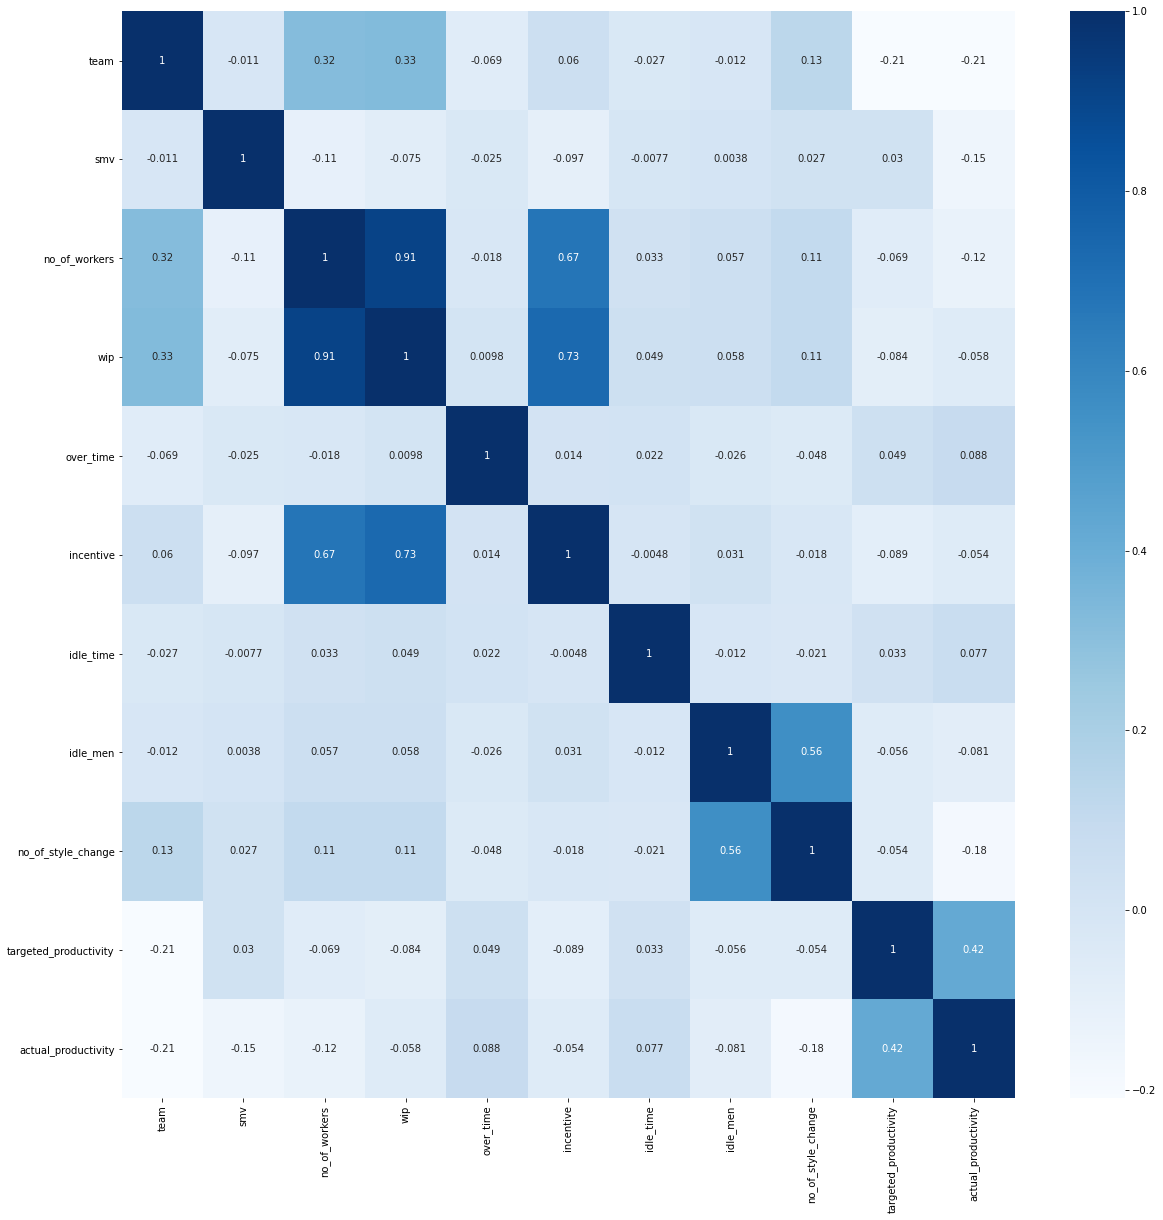

In [33]:
corrMatrix = sub_sample.corr()
plt.rcParams['figure.figsize'] = [20, 20]
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

In [35]:
vif_data = pd.DataFrame()
vif_data["feature"] = sub_sample.columns

vif_data["VIF"] = [variance_inflation_factor(sub_sample.values, i)
                          for i in range(len(sub_sample.columns))]

vif_data

,feature,VIF
0,team,1.410408
1,smv,3.516540
2,no_of_workers,14.178900
3,wip,24.784442
4,over_time,1.741784
5,incentive,6.829815
6,idle_time,1.073418
7,idle_men,1.484283
8,no_of_style_change,1.582005
9,targeted_productivity,30.810323


## Sampling

### Inverse Transform Sampling

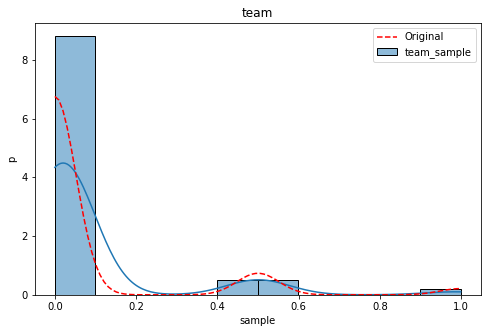

KstestResult(statistic=0.8771929824561403, pvalue=2.220446049250313e-16)


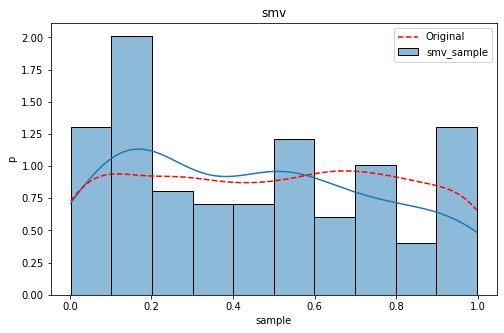

KstestResult(statistic=0.1377109440267335, pvalue=0.0543754782189122)


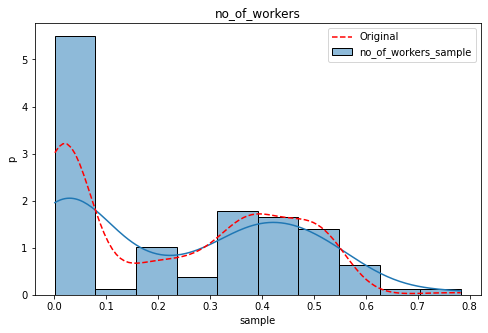

KstestResult(statistic=0.11977443609022556, pvalue=0.1297218557026003)


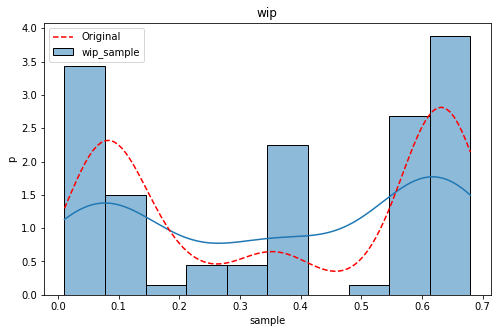

KstestResult(statistic=0.16830409356725146, pvalue=0.009333246943591722)


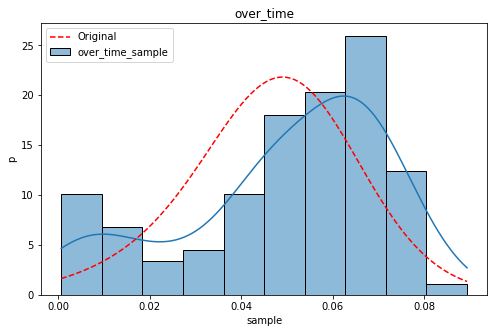

KstestResult(statistic=0.39380116959064326, pvalue=2.2315482794965646e-13)


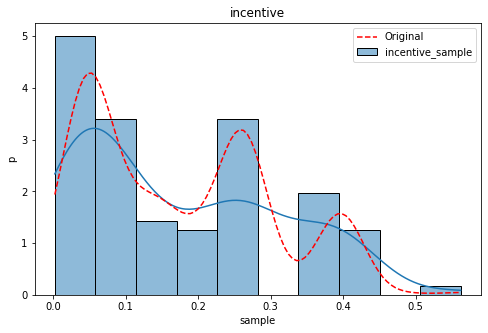

KstestResult(statistic=0.1290643274853801, pvalue=0.08399336483705877)


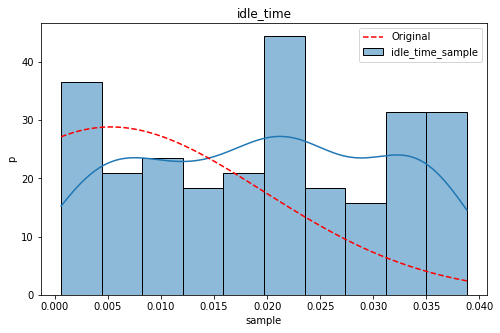

KstestResult(statistic=0.504594820384294, pvalue=2.220446049250313e-16)


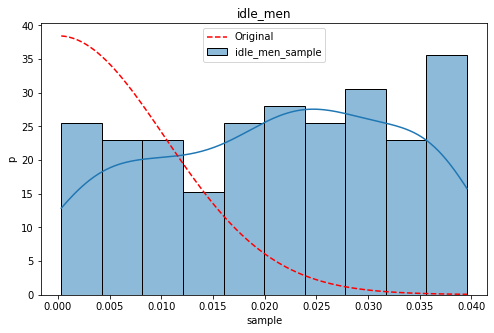

KstestResult(statistic=0.9849624060150376, pvalue=2.220446049250313e-16)


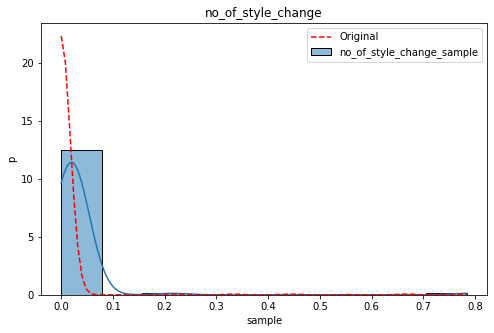

KstestResult(statistic=0.9849624060150376, pvalue=2.220446049250313e-16)


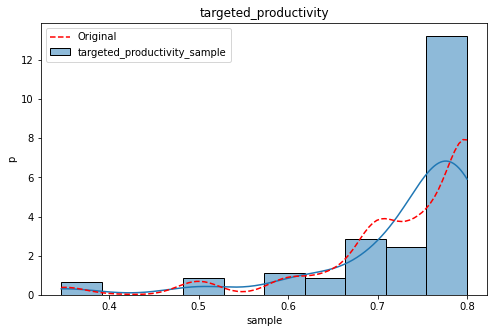

KstestResult(statistic=0.45112781954887216, pvalue=2.220446049250313e-16)


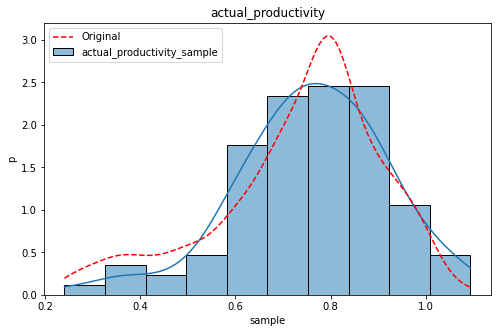

KstestResult(statistic=0.0895655806182122, pvalue=0.42319790249027134)


In [36]:
from scipy.stats import ks_2samp

from functools import partial

def inv_trans_sampling_hist(values, num_samples=1000):

    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    uniform_values = np.random.rand(num_samples)
    
    return inversed_cdf(uniform_values), n_bins



df_ = sub_sample.copy()

for target_var in sub_sample:

    plt.figure(figsize=(8, 5))
    nsample, n_bins = inv_trans_sampling_hist(df_[target_var], num_samples=100)
    x = np.linspace(nsample.min(), nsample.max(), len(nsample))
    kernel = stats.gaussian_kde(df_[target_var])
    kde_values = kernel(x)
    sns.histplot(nsample, stat='density', bins=10, kde=True, label=target_var+'_sample')
    plt.title(target_var)
    plt.plot(x, kde_values, 'r--', label='Original')
    plt.ylabel('p')
    plt.xlabel('sample')
    plt.legend()
    plt.show()
    print(ks_2samp(nsample, df_[target_var]))

### Neiman Sampling

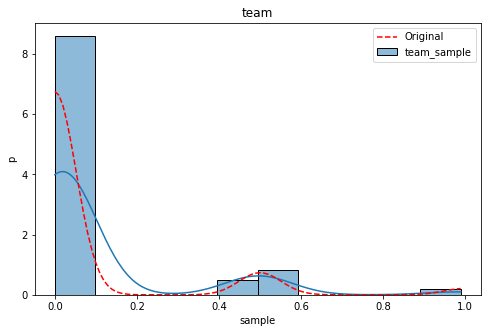

KstestResult(statistic=0.8771929824561403, pvalue=2.220446049250313e-16)


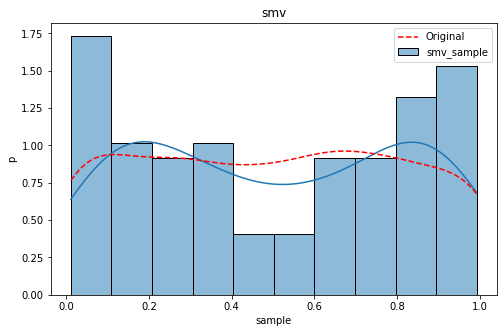

KstestResult(statistic=0.12377610693400166, pvalue=0.10796112789207146)


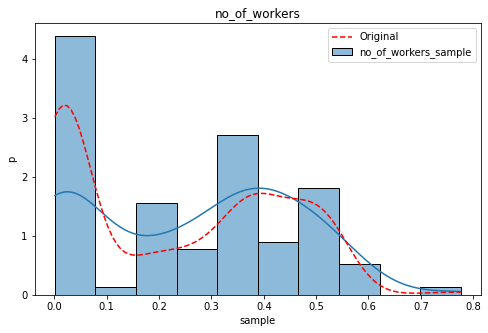

KstestResult(statistic=0.12977443609022557, pvalue=0.08112662654245262)


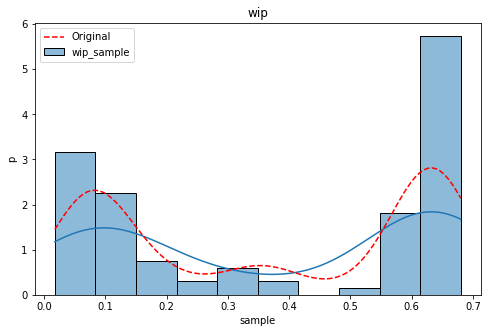

KstestResult(statistic=0.16913951545530492, pvalue=0.008850099935136635)


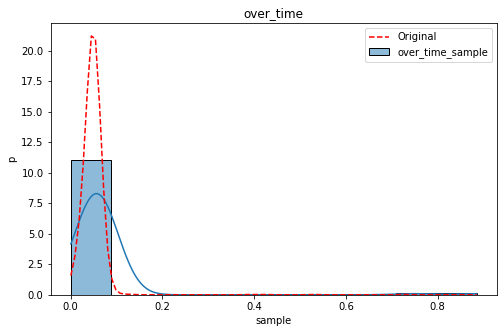

KstestResult(statistic=0.4537259816207185, pvalue=2.220446049250313e-16)


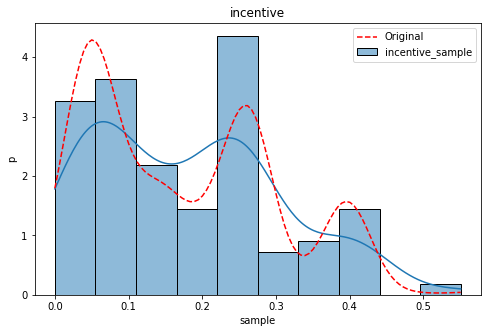

KstestResult(statistic=0.12492898913951546, pvalue=0.10234368718227338)


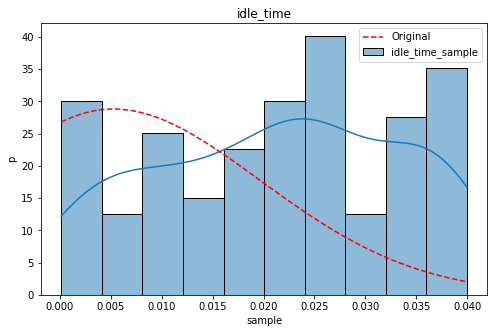

KstestResult(statistic=0.5214202172096909, pvalue=2.220446049250313e-16)


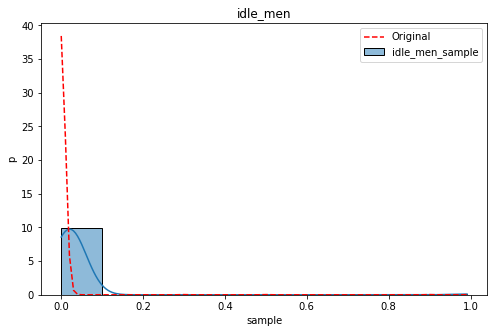

KstestResult(statistic=0.9849624060150376, pvalue=2.220446049250313e-16)


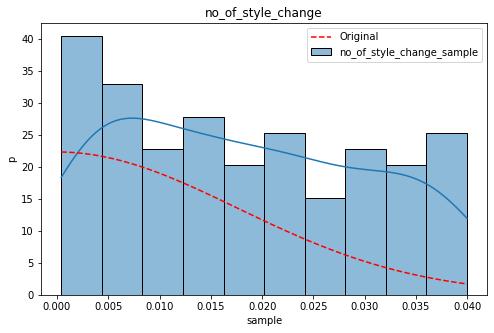

KstestResult(statistic=0.9849624060150376, pvalue=2.220446049250313e-16)


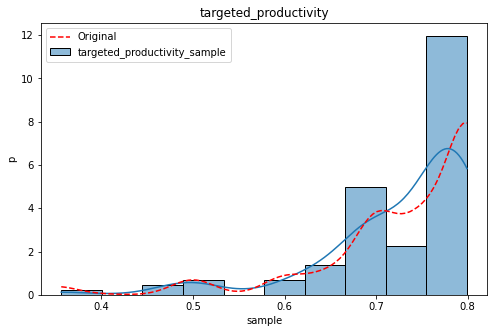

KstestResult(statistic=0.45112781954887216, pvalue=2.220446049250313e-16)


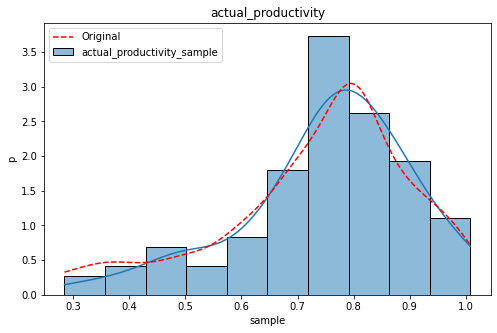

KstestResult(statistic=0.12120300751879699, pvalue=0.12154654484600758)


In [37]:
def geom_sampling_hist(values, num_samples=1000, batch_size=1000):

    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    left, right = np.min(bin_edges), np.max(bin_edges)
    bottom, top = np.min(hist), np.max(hist)
    accept_samples = np.asarray([])
    
    while accept_samples.shape[0] < num_samples:
        x_sampl = np.random.uniform(left, right, size=(batch_size,))
        y_sampl = np.random.uniform(bottom, top, size=(batch_size,))
        x_indices = np.digitize(x_sampl, bin_edges) - 1
        y_mask = (y_sampl <= hist[x_indices])
        accept_samples = np.concatenate([accept_samples, x_sampl[y_mask]])
    
    return accept_samples[:num_samples], n_bins



for target_var in sub_sample:

    plt.figure(figsize=(8, 5))
    nsample, n_bins = geom_sampling_hist(df_[target_var], num_samples=100)
    x = np.linspace(nsample.min(), nsample.max(), len(nsample))
    kernel = stats.gaussian_kde(sub_sample[target_var])
    kde_values = kernel(x)
    sns.histplot(nsample, stat='density', bins=10, kde=True, label=target_var+'_sample')
    plt.title(target_var)
    plt.plot(x, kde_values, 'r--', label='Original')
    plt.ylabel('p')
    plt.xlabel('sample')
    plt.legend()
    plt.show()
    print(ks_2samp(nsample, df_[target_var]))

### Cluster Sampling

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(sub_sample.iloc[:, -1].values.reshape(-1, 1))

In [39]:
new_sample = sub_sample.copy()
new_sample['labels'] = kmeans.labels_
new_sample.head()

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity,labels
0,0.0,0.636364,0.450252,0.655172,0.047631,0.273148,0.027222,0.0,0.0,0.80,0.940725,3
1,0.0,0.000000,0.020132,0.068966,0.051199,0.037037,0.000000,0.0,0.0,0.75,0.886500,3
2,0.0,0.909091,0.164731,0.327586,0.041575,0.141204,0.013889,0.0,0.0,0.80,0.800570,0
3,0.0,1.000000,0.164731,0.327586,0.041575,0.141204,0.013889,0.0,0.0,0.80,0.800570,0
4,0.0,0.454545,0.445219,0.620690,0.050314,0.074074,0.013889,0.0,0.0,0.80,0.800382,0


In [40]:
def cluster_sampling(df, number_of_clusters, number_of_items):

    sample = pd.DataFrame(columns=df.columns)
    item_per_cluster = -(-number_of_items//number_of_clusters)

    for index in range(number_of_clusters):
        data = df.loc[df['labels']==index].sample(item_per_cluster)
        sample = sample.append(data)
    sample = sample.iloc[:number_of_items,:].sort_index()
    return sample


In [41]:
cluster_sample = cluster_sampling(new_sample, 4, 100)
cluster_sample.head()

,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity,labels
9,0.0,0.000000,0.487418,0.637931,0.029159,0.266204,0.012500,0.0,0.0,0.75,0.750428,0
18,0.0,0.909091,0.024197,0.114943,0.051199,0.055556,0.000000,0.0,0.0,0.70,0.436326,1
43,0.0,0.454545,0.168602,0.333333,0.023015,0.269097,0.013889,0.0,0.0,0.80,0.879714,3
70,0.0,0.000000,0.450252,0.655172,0.048929,0.273148,0.017500,0.0,0.0,0.80,0.800319,0
77,0.0,0.363636,0.000000,0.068966,0.051199,0.037037,0.000000,0.0,0.0,0.60,0.759271,0


In [42]:
cluster_sample.mean(), sub_sample.mean()

(team                     0.080000
 smv                      0.441818
 no_of_workers            0.240995
 wip                      0.380920
 over_time                0.054972
 incentive                0.193652
 idle_time                0.012278
 idle_men                 0.009217
 no_of_style_change       0.016667
 targeted_productivity    0.719500
 actual_productivity      0.692496
 labels                   1.500000
 dtype: float64,
 team                     0.075188
 smv                      0.493355
 no_of_workers            0.235427
 wip                      0.374826
 over_time                0.051199
 incentive                0.176214
 idle_time                0.010614
 idle_men                 0.002434
 no_of_style_change       0.008206
 targeted_productivity    0.729632
 actual_productivity      0.735091
 dtype: float64)

In [43]:
cluster_sample.var(), sub_sample.var()

(team                     0.044040
 smv                      0.100846
 no_of_workers            0.049611
 wip                      0.073522
 over_time                0.007806
 incentive                0.023081
 idle_time                0.001429
 idle_men                 0.008101
 no_of_style_change       0.014310
 targeted_productivity    0.013025
 actual_productivity      0.045278
 labels                   1.262626
 dtype: float64,
 team                     0.045763
 smv                      0.099166
 no_of_workers            0.044873
 wip                      0.065099
 over_time                0.003646
 incentive                0.016692
 idle_time                0.001980
 idle_men                 0.001795
 no_of_style_change       0.005277
 targeted_productivity    0.009583
 actual_productivity      0.030446
 dtype: float64)

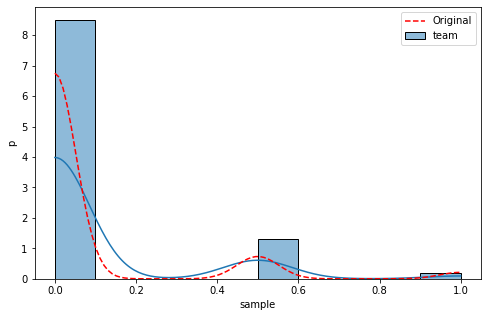

KstestResult(statistic=0.027192982456140352, pvalue=0.9999990015586168)


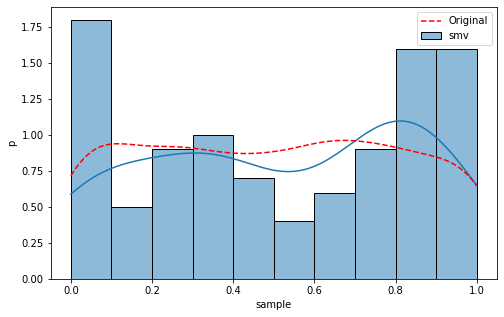

KstestResult(statistic=0.0833500417710944, pvalue=0.5140221983942701)


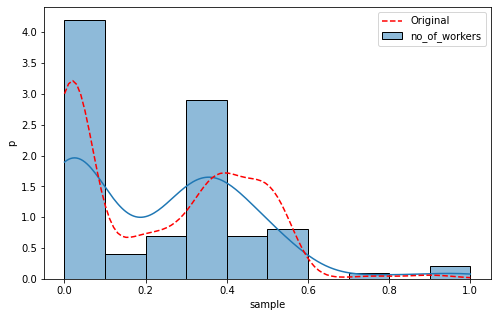

KstestResult(statistic=0.08903091060985797, pvalue=0.43033502509000376)


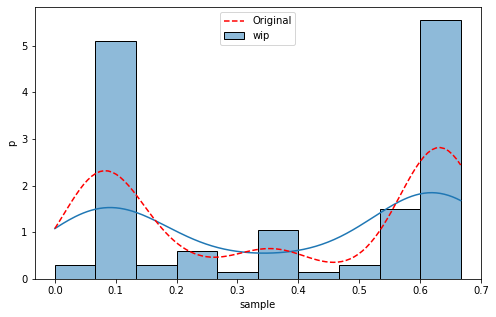

KstestResult(statistic=0.05335839598997494, pvalue=0.9414555838719771)


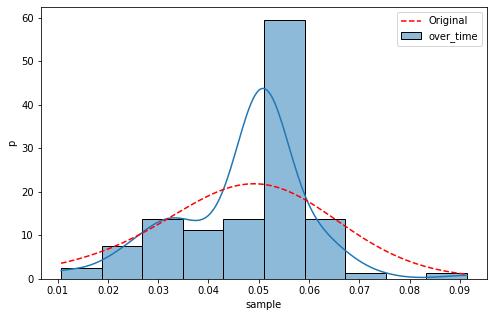

KstestResult(statistic=0.06706766917293233, pvalue=0.7734390463889322)


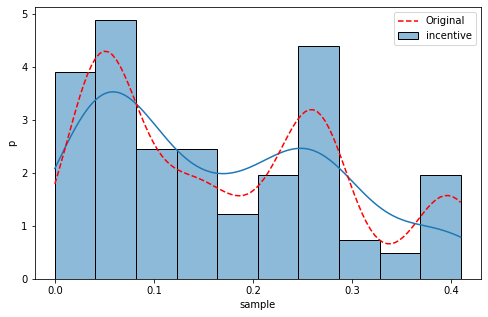

KstestResult(statistic=0.05860484544695071, pvalue=0.8892958785245892)


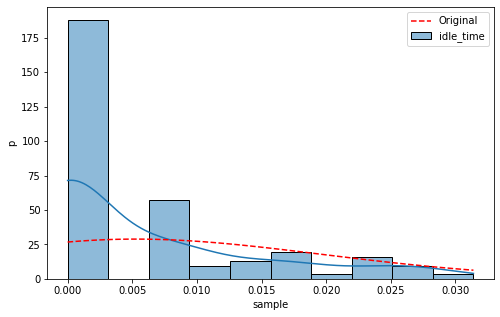

KstestResult(statistic=0.17685045948203842, pvalue=0.005349433643540125)


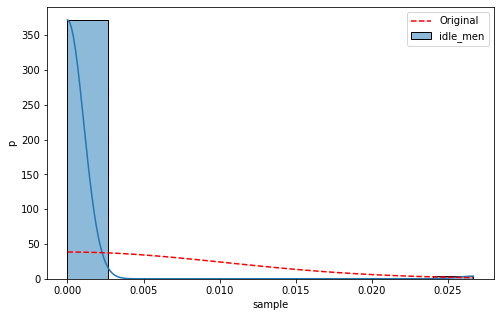

KstestResult(statistic=0.005037593984962406, pvalue=1.0)


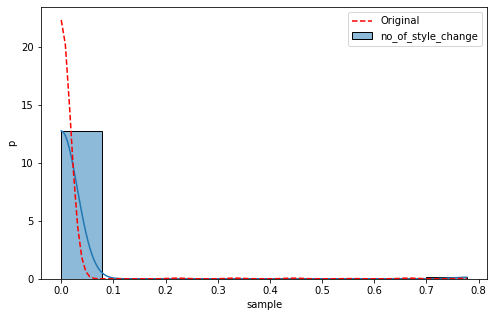

KstestResult(statistic=0.005822890559732665, pvalue=1.0)


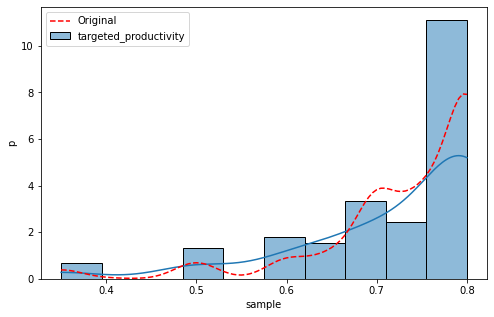

KstestResult(statistic=0.07375104427736007, pvalue=0.6673128963399444)


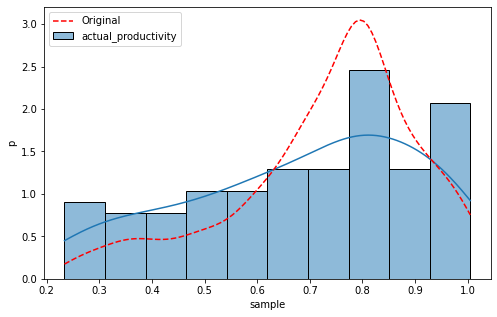

KstestResult(statistic=0.15851294903926483, pvalue=0.017050266621321142)


In [34]:
for index, column in enumerate(sub_sample.columns):
    y = cluster_sample[column]
    y_all = sub_sample[column]
    x = np.linspace(y.min(), y.max(), len(y))

    if y.var() != 0:
      plt.figure(figsize=(8, 5))
      kernel = stats.gaussian_kde(y_all)
      kde_values = kernel(x)

      sns.histplot(y, kde=True, stat='density', label=column, bins=10)
      plt.plot(x, kde_values, 'r--', label='Original')
      plt.ylabel('p')
      plt.xlabel('sample')
      plt.legend()
      plt.show()
      print(ks_2samp(y, y_all))

## Relation Predictors vs Target

In [ ]:
corrMatrix = sub_sample.corr()
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
#plt.savefig('corr.png')

## Bayesian Network

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, BDeuScore, K2Score, BicScore, HillClimbSearch, TreeSearch
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG

In [ ]:
data_sample = cluster_sample.iloc[:, :-1]
data_sample.columns

In [ ]:
transformed_data = copy(data_sample)
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(data_sample[['team','no_of_workers', 'idle_men', 'no_of_style_change']])
transformed_data[['team','no_of_workers', 'idle_men', 'no_of_style_change']] = data_discrete

In [ ]:
blacklist = [(x, y) for x in transformed_data.columns.to_list() for y in ['smv', 'wip'] if x != y]
blacklist

In [ ]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

## Basic Network

In [ ]:
model = BayesianModel([("smv", "wip"),("incentive","over_time"),("over_time", "wip"), 
                       ("wip", "targeted_productivity"),("team","targeted_productivity"),
                       ("targeted_productivity", "actual_productivity")                       
                       ])

G_bm = nx.DiGraph()
G_bm.add_edges_from(model.edges())
pos = nx.layout.circular_layout(G_bm)
plt.figure(figsize=(8,5)) 
nx.draw(G_bm, pos, with_labels=True,font_weight='bold')

In [ ]:
sample_bm = sampling(model, transformed_data, 100)
sample_bm.columns

In [ ]:
sample_bm[['incentive', 'targeted_productivity', 'over_time', 'wip']] = est.inverse_transform(sample_bm[['incentive', 'targeted_productivity', 'over_time', 'wip']].values)

In [ ]:
plt.figure(figsize=(8,5)) 
sns.histplot(data_sample['actual_productivity'], label='Original data', color='b')
sns.histplot(sample_bm['actual_productivity'], label='Generated data', color='orange')
plt.legend()

### Chow-Liu Algorithm

In [ ]:
cb = TreeSearch(transformed_data, 'team')
best_model_new = cb.estimate(estimator_type='chow-liu')
G_cb = nx.DiGraph()
G_cb.add_edges_from(best_model_new.edges())
pos = nx.layout.circular_layout(G_cb)
plt.figure(figsize=(8,5)) 
nx.draw(G_cb, pos, with_labels=True,font_weight='bold')

In [ ]:
sample_cb = sampling(best_model_new, transformed_data, 100)
sample_cb.columns

In [ ]:
sample_cb[['incentive', 'targeted_productivity', 'over_time', 'smv']] = est.inverse_transform(sample_cb[['incentive', 'targeted_productivity', 'over_time', 'smv']].values)

In [ ]:
plt.figure(figsize=(8,5)) 
sns.histplot(data_sample['actual_productivity'], label='Original data', color='b')
sns.histplot(sample_cb['actual_productivity'], label='Generated data', color='orange')
plt.legend()

### HillClimb Search Algorithm

In [ ]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))
best_model_new = hc.estimate(black_list=blacklist)
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_new.edges())
pos = nx.layout.circular_layout(G_K2)
plt.figure(figsize=(8,5)) 
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [ ]:
sample_K2 = sampling(best_model_new, transformed_data, 100)
sample_K2.columns

In [ ]:
sample_K2[['incentive', 'targeted_productivity', 'over_time', 'wip']] = est.inverse_transform(sample_K2[['incentive', 'targeted_productivity', 'over_time', 'wip']].values)

In [ ]:
plt.figure(figsize=(8,5)) 
sns.histplot(data_sample['actual_productivity'], label='Original data', color='b')
sns.histplot(sample_K2['actual_productivity'], label='Generated data', color='orange')
plt.legend()

### Performance Metrics

In [ ]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error

In [ ]:
plt.figure(figsize=(8, 5))
kernel = stats.gaussian_kde(data_sample['actual_productivity'])
min_amount, max_amount = data_sample['actual_productivity'].min(), data_sample['actual_productivity'].max()
x = np.linspace(min_amount, max_amount, len(data_sample['actual_productivity']))

kernel2 = stats.gaussian_kde(sample_bm['actual_productivity'])
kernel3 = stats.gaussian_kde(sample_K2['actual_productivity'])
kernel4 = stats.gaussian_kde(sample_cb['actual_productivity'])

kde_values = kernel(x)
kde_values_bm = kernel2(x)
kde_values_k2 = kernel3(x)
kde_values_cb = kernel4(x)

plt.plot(x, kde_values, label="Original Sample")
plt.plot(x, kde_values_bm, label="Generated Sample-SimpleBN")
plt.plot(x, kde_values_k2, label="Generated Sample-HCK2Score")
plt.plot(x, kde_values_cb, label="Generated Sample-ChowLiu")
plt.title('KDE')
plt.ylabel('p')
plt.xlabel('actual_productivity')
plt.legend()
plt.show()

In [ ]:
y_true = np.sort(data_sample['actual_productivity'])
y_pred_2 = np.sort(sample_K2['actual_productivity'])
y_pred_3 = np.sort(sample_cb['actual_productivity'])
y_pred_4 = np.sort(sample_bm['actual_productivity'])

print("R2 Score (HC Approach-K2Score):",r2_score(y_true, y_pred_2))
print("R2 Score (Chow-Liu Approach):",r2_score(y_true, y_pred_3))
print("R2 Score (Simple BN):",r2_score(y_true, y_pred_4))

print("\n")
print("MSE (HC Approach-K2Score):",mean_squared_error(y_true, y_pred_2))
print("MSE (Chow-Liu Approach):",mean_squared_error(y_true, y_pred_3))
print("MSE (Simple BN):",mean_squared_error(y_true, y_pred_4))

print("\n")
print("MAE (HC Approach-K2Score):",mean_absolute_error(y_true, y_pred_2))
print("MAE (Chow-Liu Approach):",mean_absolute_error(y_true, y_pred_3))
print("MAE (Simple BN):",mean_absolute_error(y_true, y_pred_4))